In [1]:
import bisect
import datetime as dt
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
URL = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
FILENAME = 'data/time_series_covid19_confirmed_global.csv'

with urllib.request.urlopen(URL) as testfile, open(FILENAME, 'w') as f:
    f.write(testfile.read().decode())

data = pd.read_csv(FILENAME)
data.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,4/4/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,94,110,110,120,170,174,237,273,281,299
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,174,186,197,212,223,243,259,277,304,333
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,367,409,454,511,584,716,847,986,1171,1251
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,224,267,308,334,370,376,390,428,439,466
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,4,4,5,7,7,7,8,8,8,10


In [3]:
dates = []
cases = []
cases_wo_us = []
last_day = dt.datetime.utcnow().date() - dt.timedelta(days=1)
first_day = last_day - dt.timedelta(days=30)

for c in data.columns:
    if c.endswith('/20'):
        dates.append(dt.datetime.strptime(c, '%m/%d/%y').date())
        cases.append(data[c].sum())
        cases_wo_us.append(data[data['Country/Region'] != 'US'][c].sum())
        
si = bisect.bisect_left(dates, first_day)

def new_cases(cases):
    return [cases[i] - (cases[i-1] if i > 0 else 0) for i in range(len(cases))]

def growth_factor(cases):
    n_cases = new_cases(cases)
    return [(n_cases[i] / n_cases[i-1]) if i > 0 else 1 for i in range(len(n_cases))]

In [4]:
cases_data = pd.DataFrame(list(zip(dates, cases, new_cases(cases), growth_factor(cases))),
                          columns=['Date', 'Total cases', 'New cases', 'Growth factor'])
cases_data.tail()

,Date,Total cases,New cases,Growth factor
69,2020-03-31,857487,75122,1.206818
70,2020-04-01,932605,75118,0.999947
71,2020-04-02,1013157,80552,1.072340
72,2020-04-03,1095917,82760,1.027411
73,2020-04-04,1197405,101488,1.226293


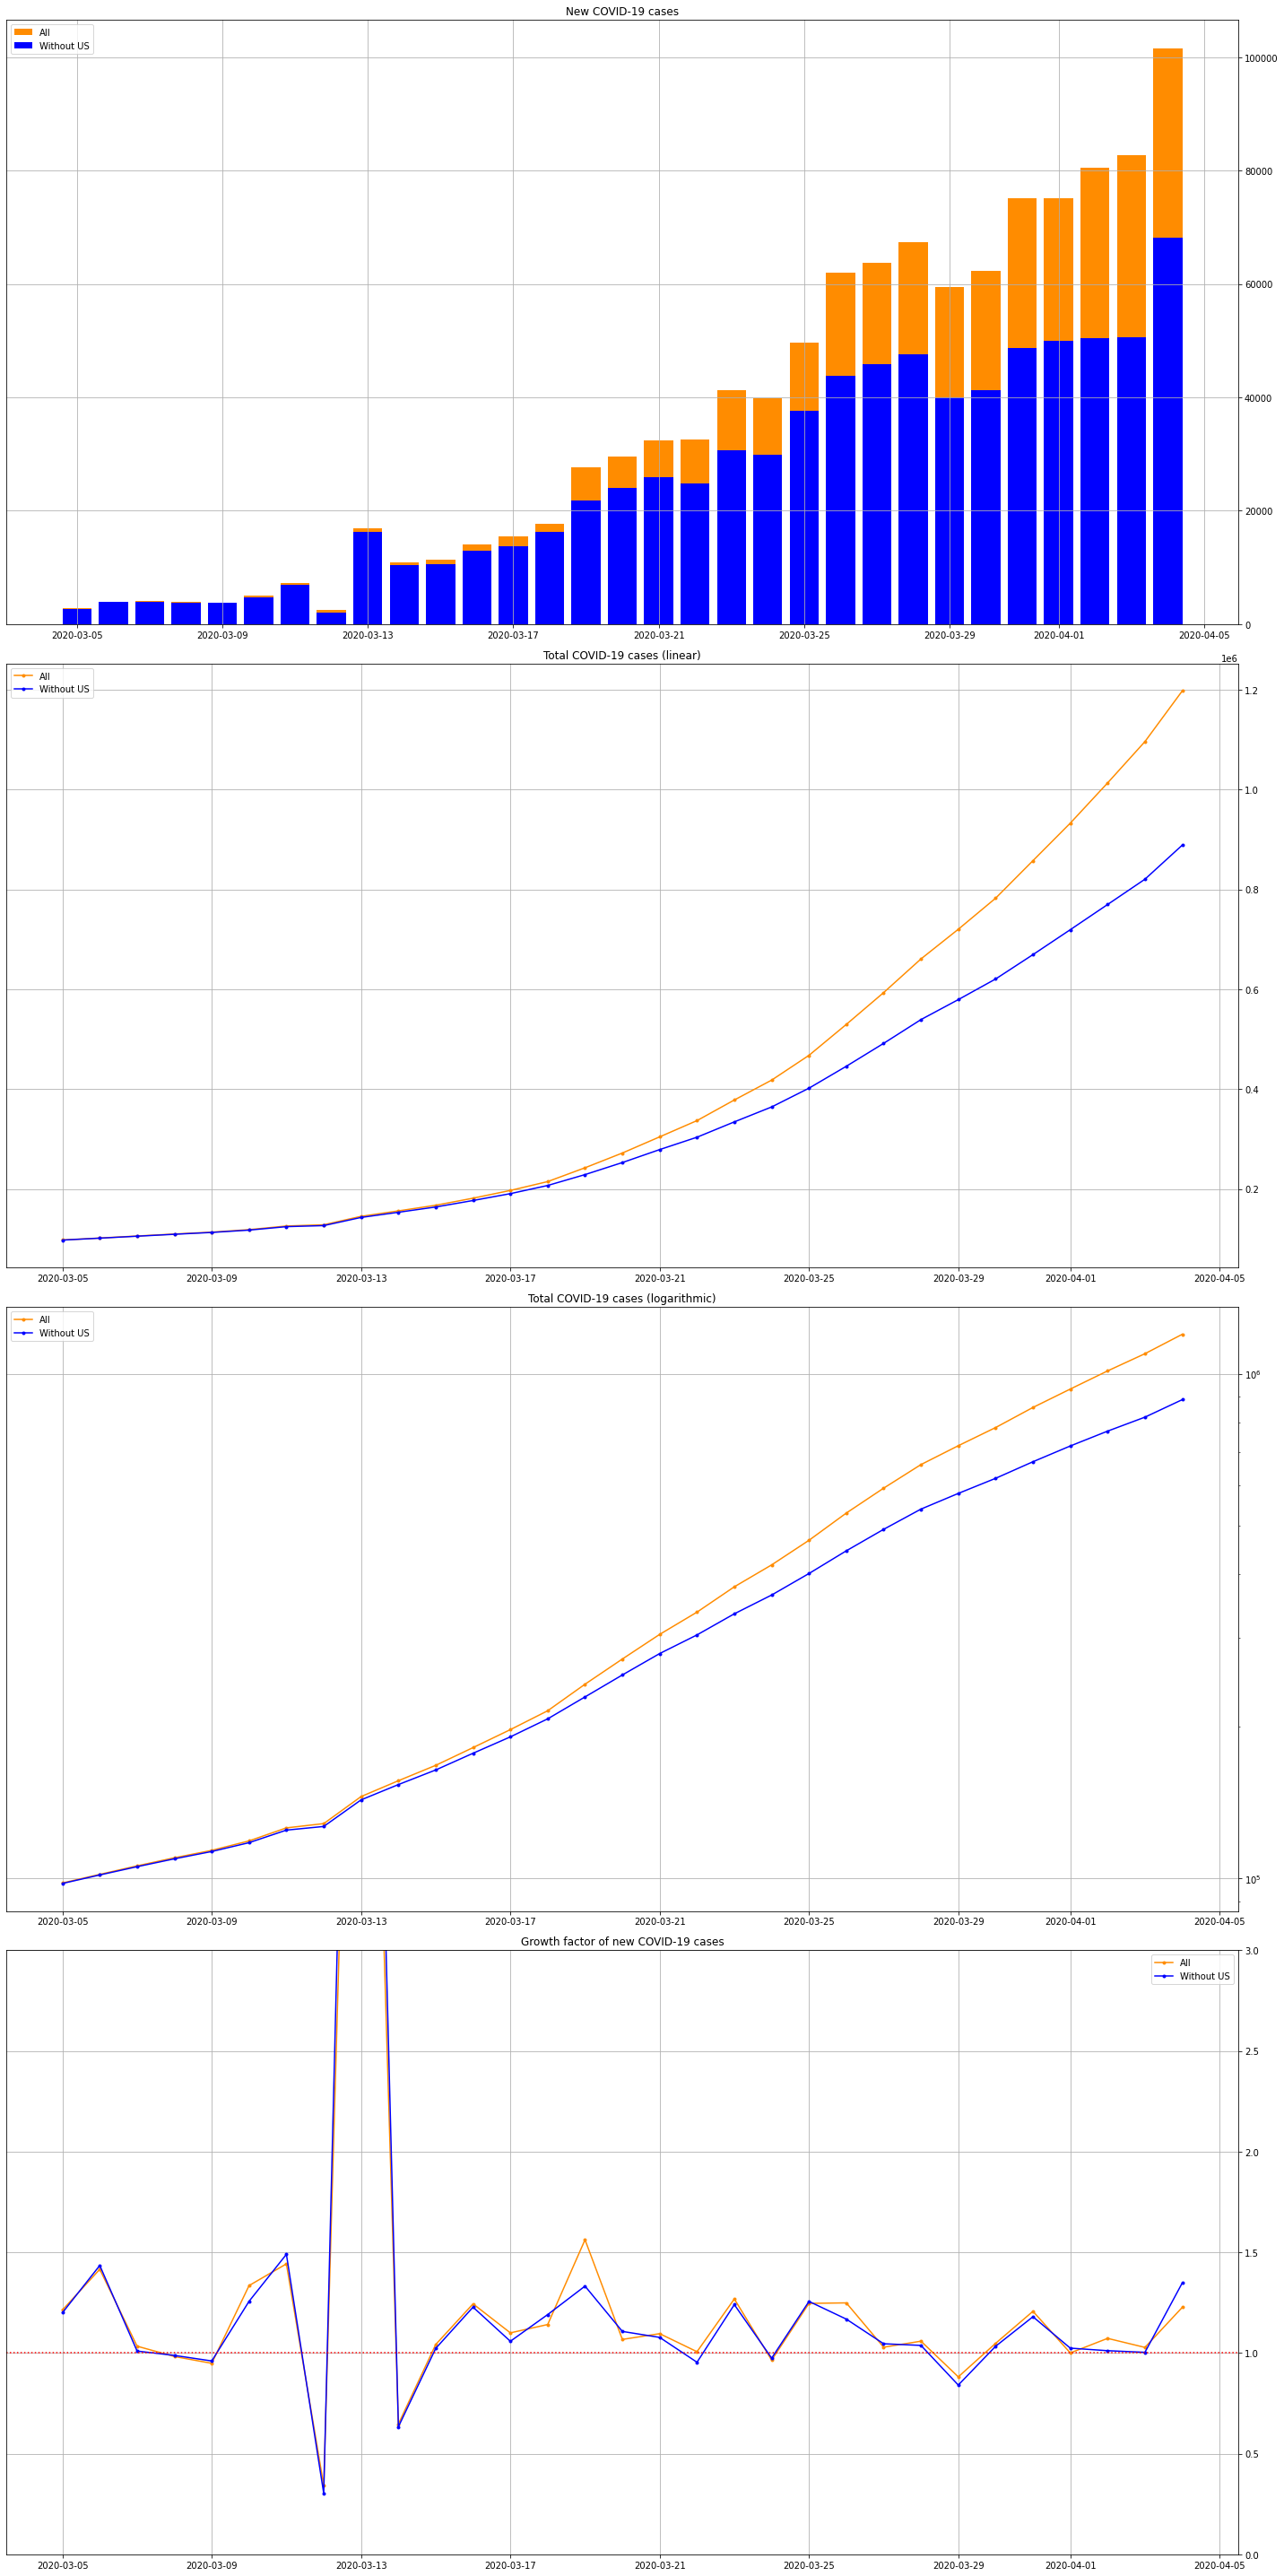

In [5]:
ALL_COLOR = '#ff8c00'
WO_US_COLOR = '#0000ff'
RESULT_FILE = 'graphs/CO'


fig = plt.figure(figsize=(20, 40))

nc_ax = plt.subplot(411)
nc_ax.bar(dates[si:], new_cases(cases)[si:], color=ALL_COLOR, label='All')
nc_ax.bar(dates[si:], new_cases(cases_wo_us)[si:], color=WO_US_COLOR, label='Without US')
nc_ax.grid(True)
nc_ax.yaxis.tick_right()
nc_ax.legend()
nc_ax.set_title('New COVID-19 cases')

tc_ax = plt.subplot(412)
tc_ax.plot(dates[si:], cases[si:], marker='.', color=ALL_COLOR, label='All')
tc_ax.plot(dates[si:], cases_wo_us[si:], marker='.', color=WO_US_COLOR, label='Without US')
tc_ax.grid(True)
tc_ax.yaxis.tick_right()
tc_ax.legend()
tc_ax.set_title('Total COVID-19 cases (linear)')

tc_log_ax = plt.subplot(413)
tc_log_ax.plot(dates[si:], cases[si:], marker='.', color=ALL_COLOR, label='All')
tc_log_ax.plot(dates[si:], cases_wo_us[si:], marker='.', color=WO_US_COLOR, label='Without US')
tc_log_ax.set_yscale('log')
tc_log_ax.grid(True)
tc_log_ax.yaxis.tick_right()
tc_log_ax.legend()
tc_log_ax.set_title('Total COVID-19 cases (logarithmic)')

gf_ax = plt.subplot(414)
gf_ax.plot(dates[si:], growth_factor(cases)[si:], marker='.', color=ALL_COLOR, label='All')
gf_ax.plot(dates[si:], growth_factor(cases_wo_us)[si:], marker='.', color=WO_US_COLOR, label='Without US')
gf_ax.axhline(y=1.0, c='r', ls=':')
gf_ax.set_ylim(bottom=0, top=3)
gf_ax.grid(True)
gf_ax.yaxis.tick_right()
gf_ax.legend()
gf_ax.set_title('Growth factor of new COVID-19 cases')

plt.tight_layout()
plt.savefig('COVID-19 plots.pdf')
plt.show()